In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from IPython import display
from pathlib import Path
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (16,7)
sns.set_style("whitegrid")
model_dir = Path("../exp/train_lstm_words_pretrained_curriculum/v5")

## Training

In [3]:
tags = ["o", "ok", "mono", "all"]
        
results = pd.DataFrame()
for tag in tags:
    jsonfile = Path(model_dir, "train", tag, "results", "log")
    if not jsonfile.exists():
        continue
    df = pd.read_json(jsonfile)
    df["dataset"] = tag
    results = pd.concat([results, df], axis=0)
    print(len(df))
    
results = (
    results
    .assign(new_dataset=(results.index == 0))
    .reset_index(drop=True)
)

results

37
32
97
321


,main/loss,main/accuracy,eps,epoch,iteration,elapsed_time,validation/main/loss,validation/main/accuracy,dataset,new_dataset
0,0.068355,0,1.000000e-08,0,100,55.926515,NaN,NaN,o,True
1,0.064127,0,1.000000e-08,1,200,112.112988,0.063595,0.0,o,False
2,0.063258,0,1.000000e-08,2,300,156.622731,0.061764,0.0,o,False
3,0.063149,0,1.000000e-08,3,400,202.456421,0.061104,0.0,o,False
4,0.062597,0,1.000000e-08,4,500,248.679460,0.060628,0.0,o,False
...,...,...,...,...,...,...,...,...,...,...
482,0.051061,0,1.000000e-08,18,31700,9044.288605,NaN,NaN,all,False
483,0.050965,0,1.000000e-08,18,31800,9069.818402,NaN,NaN,all,False
484,0.051167,0,1.000000e-08,18,31900,9097.220849,NaN,NaN,all,False
485,0.050227,0,1.000000e-08,18,32000,9124.556632,NaN,NaN,all,False


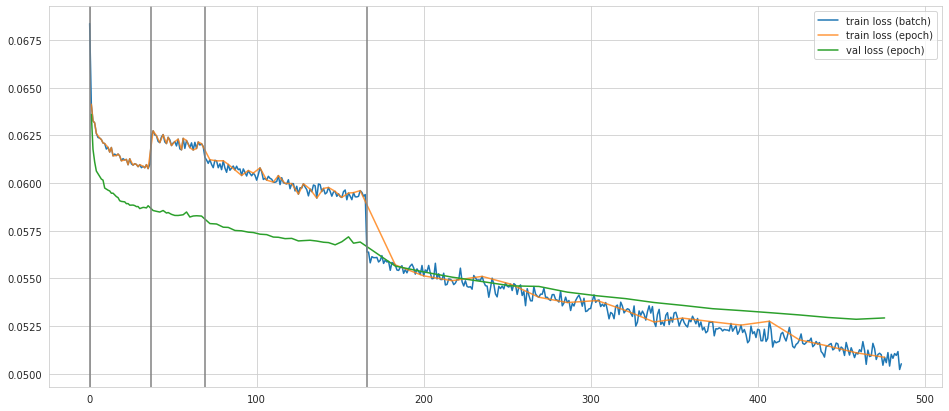

In [4]:
ax = results["main/loss"].plot(label="train loss (batch)", legend=False)
epoch_mask = results["validation/main/loss"].notnull()
results.loc[epoch_mask, "main/loss"].dropna(how="any").plot(ax=ax, label="train loss (epoch)", legend=False, alpha=.8)
results.loc[epoch_mask, "validation/main/loss"].dropna(how="any").plot(ax=ax, label="val loss (epoch)", legend=False)
ax.legend()
for xi in results[results["new_dataset"]].index:
    ax.axvline(xi, color='gray')

In [5]:
# sort_order = lambda row: tags.index(row["dataset"]) * 1000 + row["epoch"]
# epochs = (results
#           .groupby(["dataset", "epoch"])
#           .agg({"main/loss": "mean", "validation/main/loss": "mean"})
#           .reset_index()
#           .assign(sort_order=lambda df: df.apply(sort_order, axis=1))
#           .sort_values("sort_order")
#           .drop("sort_order", axis=1)
#           .reset_index())

# epochs[["main/loss", "validation/main/loss"]].plot();

In [6]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))
# ax1.plot(np.arange(len(train_losses)), train_losses)
# ax2.plot(np.arange(1, len(ep_tr_losses) + 1), ep_tr_losses, label="train") 
# ax2.plot(np.arange(1, len(ep_tr_losses) + 1), val_losses, label="validation")
# for x in [20,39,58]:
#     ax2.axvline(x=x, color="grey")
# ax2.legend()
# plt.tight_layout();

## Evaluation

In [186]:
def load_batch(batch_nr):
    result_dir = Path(model_dir, "evaluate", "results")
    output_files = list(result_dir.glob("*.npy"))
    
    attn_weights = np.load(list(filter(lambda p: p.stem == f"att_weights_batch{i}", output_files))[0])
    ids = np.load(list(filter(lambda p: p.stem == f"id_batch{i}", output_files))[0])
    targets = np.load(list(filter(lambda p: p.stem == f"target_batch{i}", output_files))[0])
    target_lengths = np.load(list(filter(lambda p: p.stem == f"target_lengths{i}", output_files))[0])
    preds = np.load(list(filter(lambda p: p.stem == f"predictions_batch{i}", output_files))[0])

    return {
        "attention": attn_weights,
        "uttids": ids,
        "targets": targets,
        "target_lengths": target_lengths,
        "predictions": preds
    }

def score(y_pred, y_true, ylen):
    return ((y_pred[:ylen] - y_true[:ylen]) ** 2).mean()

def batch_scores(batch):
    return np.array([score(
        batch["predictions"][i], 
        batch["targets"][i],
        batch["target_lengths"][i]
    ) for i in range(len(batch["predictions"]))])


In [183]:
with open("../dump/CGN_test/deltafalse/data_words.all.json") as f:
    test_set = json.load(f)["utts"]
    
batch = load_batch(0)

IndexError: list index out of range

In [189]:
batch_scores(batch)

array([0.7297643 , 0.98914224, 0.8396907 , 0.82810473, 1.0096604 ,
       1.0200596 , 0.9210314 , 1.007402  , 0.9261652 , 0.8600511 ,
       0.95266277, 0.6142178 , 1.0213938 , 0.7993727 , 0.8351741 ,
       0.7452991 , 0.86330056, 0.8608407 , 0.7845554 , 0.6994439 ,
       0.76028985, 0.7099444 , 0.76699156, 1.0293921 , 1.0065831 ,
       0.6712255 , 0.9960851 , 0.7422781 , 0.6666679 , 0.5818842 ,
       0.82027745, 0.7534056 , 0.86936784, 1.0157373 , 0.89695436,
       0.87109196, 1.0126152 , 0.8071534 , 0.83505493, 0.9497587 ,
       0.952604  , 0.7158018 , 0.97991455, 0.6045708 , 1.0198964 ,
       0.80149597, 0.83163124, 0.85328734, 0.7868289 , 0.8265006 ,
       1.0049958 , 0.8284307 , 0.99593854, 0.9845838 , 0.7242823 ,
       0.9912855 , 0.65439564, 1.022512  , 0.99568605, 1.0309861 ,
       0.9953149 , 0.8139198 , 1.0071843 , 0.9028981 ], dtype=float32)

In [181]:
batch["targets"][-1].shape, batch["predictions"][-1].shape

((136, 100), (137, 100))

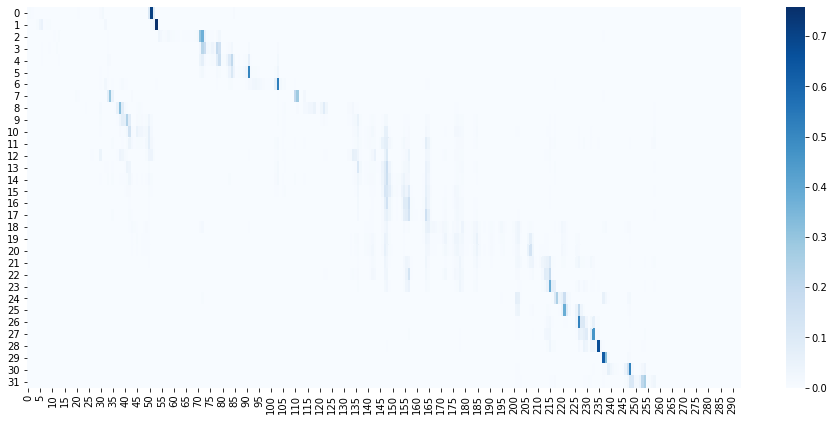

In [179]:
i = -1
sns.heatmap(batch["attention"][i][:batch["target_lengths"][i]], cmap="Blues");

In [190]:
def Embedding(num_embeddings, embedding_dim, eos_idx, eos_value=0):
    m = nn.Embedding(num_embeddings, embedding_dim)
    nn.init.uniform_(m.weight, -0.1, 0.1)
    nn.init.constant_(m.weight[eos_idx], eos_value)
    return m


def load_pretrained_embedding_from_file(embed_path, vocab, freeze=True, eos_idx=-1, eos_value=0):
    vocab = vocab.copy()
    num_embeddings = len(vocab)
    # eos_idx MUST be -1 (= the last one) otherwise, we will have a clash with the other indices
    # Note: can be easily solved in load_embedding, but does not matter a.t.m.
    assert eos_idx == -1 or eos_idx == num_embeddings - 1
    embed_dict = parse_embedding(embed_path)
    embed_dim = embed_dict[list(embed_dict)[0]].size(0)
    embed_tokens = Embedding(num_embeddings, embed_dim, eos_idx, eos_value)
    embed_tokens.weight.requires_grad = not freeze
    return load_embedding(embed_dict, vocab, embed_tokens)


def load_embedding(embed_dict, vocab, embedding):
    """[From fairseq]"""
    for idx in range(len(vocab)):
        token = vocab[idx]
        if token in embed_dict:
            embedding.weight.data[idx] = embed_dict[token]
    return embedding


def parse_embedding(embed_path):
    """[From fairseq] Parse embedding text file into a dictionary of word and embedding tensors.
    The first line can have vocabulary size and dimension. The following lines
    should contain word and embedding separated by spaces.
    Example:
        2 5
        the -0.0230 -0.0264  0.0287  0.0171  0.1403
        at -0.0395 -0.1286  0.0275  0.0254 -0.0932
    """
    embed_dict = {}
    with open(embed_path, encoding='utf-8') as f_embed:
        next(f_embed)  # skip header
        for line in f_embed:
            pieces = line.rstrip().split(" ")
            embed_dict[pieces[0]] = torch.Tensor(
                [float(weight) for weight in pieces[1:]]
            )
    return embed_dict

In [192]:
with open(Path(model_dir, "train/all/results/model.json")) as jsonfile:
    idim, odim, model_config = json.load(jsonfile)

target_dict = model_config["char_list"]
    
EMB_PATH = "/esat/spchdisk/scratch/qmeeus/repos/espnet/egs/cgn/asr1/data/lang_word/w2v_small.txt"
embed_token = load_pretrained_embedding_from_file(
    EMB_PATH, target_dict, freeze=True, eos_idx=-1
)

embed_token

Embedding(52165, 100)

In [194]:
len(target_dict)

52165

In [120]:
target_dict[-1]

'<eos>'

In [122]:
np.where?

In [125]:
target0_ = np.where(target0 == -1, np.ones_like(target0) * (len(target_dict) - 1), target0)
target0_emb = embed_token(torch.from_numpy(target0_))


torch.Size([64, 32, 100])

In [206]:
import torch.nn.functional as F
from sklearn.neighbors import KNeighborsClassifier

def encode(tokens):
    vocab_size = 52165
    return F.one_hot(tokens, vocab_size)

emb_weights = 

tokens = torch.tensor([target_dict.index(w) for w in "ik ben blij".split()])
encoded = encode(tokens)
embedded = embed_token(tokens)



In [215]:
clf = KNeighborsClassifier(n_neighbors=1).fit(embed_token.weight, np.arange(len(target_dict)))

In [212]:
clf.predict(embedded)

array([19540,  4307,  5904])

In [216]:
clf?

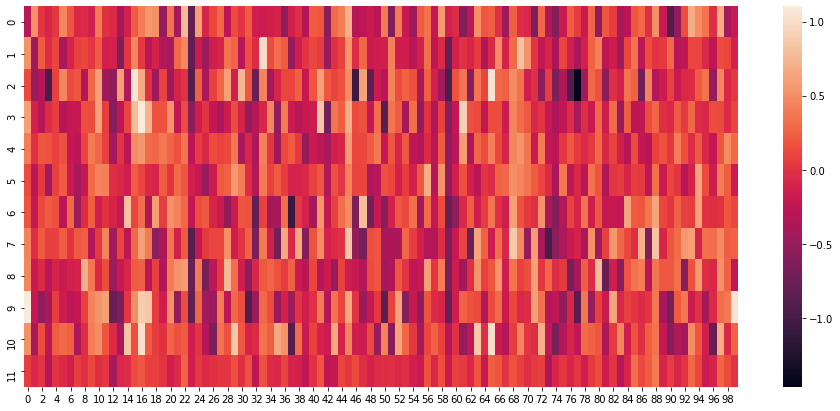

In [145]:
sns.heatmap(target0_emb[0,:target_lengths[0]])

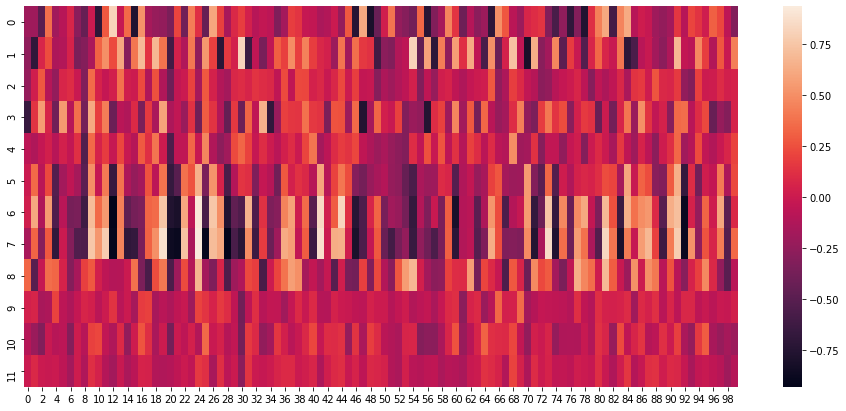

In [143]:
sns.heatmap(torch.from_numpy(pred0[0,:target_lengths[0]]))

In [ ]:
targets = [np.load(p) for p in result_dir.glob("target_batch*.npy")]
predictions = [np.load(p) for p in result_dir.glob("predictions_batch*.npy")]